<a href="https://colab.research.google.com/github/mohamedalifaragitiai/Computer-Vision-Image_Processing/blob/main/Session_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# log into drive from colab
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/AMIT/CVCourse/images 


/content/drive/MyDrive/AMIT/CVCourse/images


In [4]:
from __future__ import print_function
import cv2, matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from skimage.io import imread
%matplotlib inline

**Image Segmentation**

**Manual Thresholding**

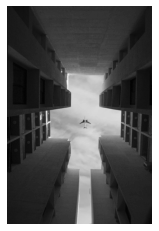

In [5]:
im = imread('airplane.jpg')

plt.figure()
plt.imshow(im, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

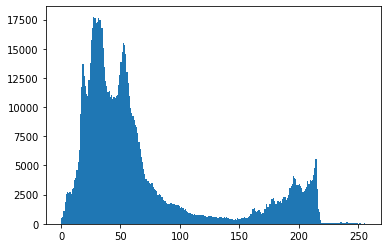

In [6]:
plt.figure()
plt.hist(im.flatten(), bins=np.arange(257))
plt.show()

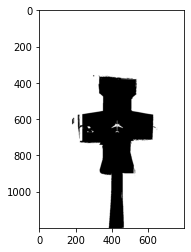

In [7]:
# Manual threshold
im_binary = im<150

plt.figure()
plt.imshow(im_binary, cmap=plt.cm.gray)
plt.show()

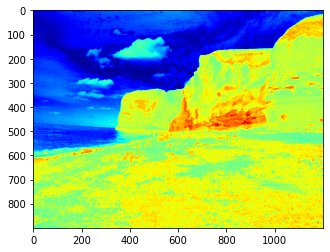

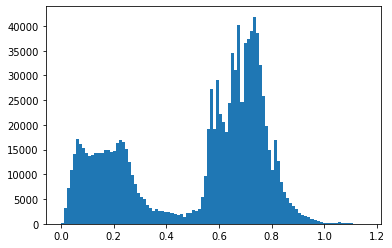

In [8]:
from skimage.color import rgb2hsv

def distance_image_space(im, coords):
    dmap = np.zeros((im.shape[0], im.shape[1]))
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            dmap[i,j] = np.sqrt((i-coords[0])**2 + (j-coords[1])**2)
    
    return dmap

def distance_color_space(im, coords):
    refcolor = im[coords[0],coords[1]]
    dmap = np.sqrt(((im-refcolor)**2).sum(axis=2))
    #np.zeros((im.shape[0], im.shape[1]))
    #for i in range(im.shape[0]):
    #    for j in range(im.shape[1]):
    #        dmap[i,j] = np.sqrt(((im[i,j]-refcolor)**2).sum())
    
    return dmap

im = imread('etretat.jpg')
hsv = rgb2hsv(im)

coords = (200,600)

dmap = distance_color_space(hsv.astype('float'), coords)

plt.figure()
plt.imshow(dmap, cmap=plt.cm.jet)
plt.show()

plt.figure()
plt.hist(dmap.flatten(), bins=100)
plt.show()

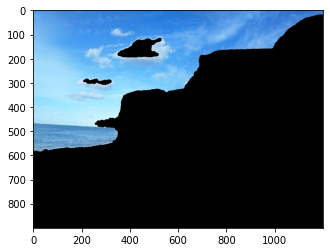

In [9]:
from skimage.morphology import opening,closing,disk

mask = (dmap<0.4)
mask = closing(opening(mask, disk(5)),disk(5))

im_m = im.copy()
im_m[mask==False] = 0

plt.figure()
plt.imshow(im_m)
plt.show()

**Automatic Thresholding**

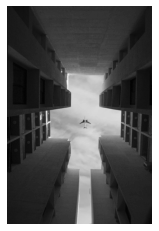

In [10]:
im = imread('airplane.jpg')

plt.figure()
plt.imshow(im, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

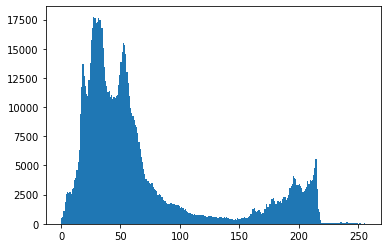

In [11]:
plt.figure()
plt.hist(im.flatten(), bins=np.arange(257))
plt.show()

In [12]:
def optimal_threshold(h,t):
    # Cut distribution in 2
    h1 = h[:t]
    h2 = h[t:]
    
    # Compute the centroids
    m1 = (h1*np.arange(0,t)).sum()/h1.sum()
    m2 = (h2*np.arange(t,len(h))).sum()/h2.sum()
    
    # Compute the new threshold
    t2 = int(np.round((m1+m2)/2))
    print(m1,m2,t2)
    
    if( t2 != t ) : return optimal_threshold(h,t2)
    return t2

h,bins = np.histogram(im,range(257))
t = optimal_threshold(h,240)
print(t)

67.97246560416244 245.48888888888888 157
45.81617271349327 194.79630569087612 120
43.60119368139627 187.89667799516243 116
43.32364932456779 186.63467158991136 115
43.25549460250202 186.31132064176245 115
115


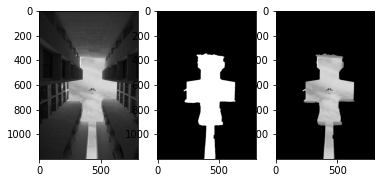

In [13]:
from skimage.morphology import opening,closing,disk

mask = im>t
mask = closing(opening(mask, disk(5)),disk(7))

im_m = im.copy()
im_m[mask==False] = 0

plt.figure()
plt.subplot(1,3,1)
plt.imshow(im, cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.imshow(mask, cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.imshow(im_m, cmap=plt.cm.gray)
plt.show()

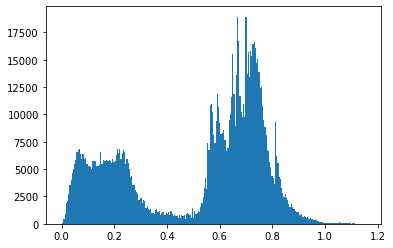

In [14]:
from skimage.color import rgb2hsv

def distance_color_space(im, coords):
    refcolor = im[coords[0],coords[1]]
    dmap = np.sqrt(((im-refcolor)**2).sum(axis=2))
    return dmap

im = imread('etretat.jpg')
hsv = rgb2hsv(im)

coords = (200,600)

dmap = distance_color_space(hsv.astype('float'), coords)
h,bins = np.histogram(dmap.flatten(),bins=256)

plt.figure()
plt.bar(bins[:-1],h,bins[1]-bins[0])
plt.show()

In [15]:
b = optimal_threshold(h,127)
t = (bins[b]+bins[b+1])/2
print(t)

51.57976091340165 156.81519536835634 104
39.5778866340098 153.5479349575135 97
38.786211522573154 153.18817428171252 96
38.67977380757253 153.13362467434237 96
0.43545112783247764


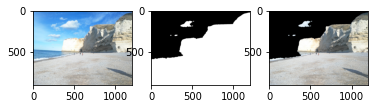

In [16]:
mask = dmap>t
mask = closing(opening(mask, disk(5)),disk(5))

im_m = im.copy()
im_m[mask==False] = 0

plt.figure()
plt.subplot(1,3,1)
plt.imshow(im, cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.imshow(mask, cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.imshow(im_m, cmap=plt.cm.gray)
plt.show()

**Otsu threshold algorithm**

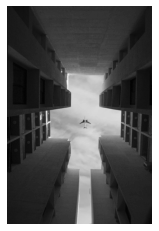

In [17]:
im = imread('airplane.jpg')

plt.figure()
plt.imshow(im, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

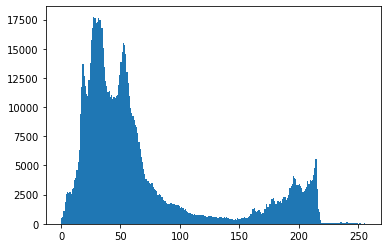

In [18]:
plt.figure()
plt.hist(im.flatten(), bins=np.arange(257))
plt.show()

In [19]:
def otsu_threshold(h):
    h = h*1./h.sum() # Probability histogram
    
    # Check every possible threshold
    var_within = np.zeros(len(h))
    var_between = np.zeros(len(h))
    sep = np.zeros(len(h))
    
    for t in range(1,len(h)-1):
        # Class probabilities
        w1 = h[:t].sum()
        w2 = h[t:].sum()
        # Class means
        m1 = (np.arange(0,t)*h[:t]).sum()/w1
        m2 = (np.arange(t,len(h))*h[t:]).sum()/w2
        # Class variances
        s1 = (((np.arange(0,t)-m1)**2)*h[:t]).sum()/w1
        s2 = (((np.arange(t,len(h))-m2)**2)*h[t:]).sum()/w2
        # Intra-class
        sw = w1*s1+w2*s2
        # Inter-class
        sb = w1*w2*((m2-m1)**2)
        # Separability
        var_within[t] = sw
        var_between[t] = sb
    
    sep[1:-1] = var_between[1:-1]/var_within[1:-1]
    best_t = np.argmax(sep)
    
    return best_t, var_within, var_between, sep

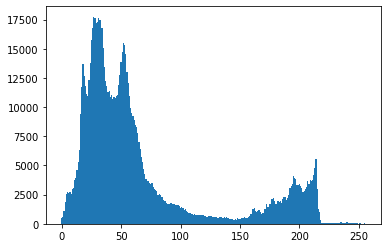

Otsu threshold : 115


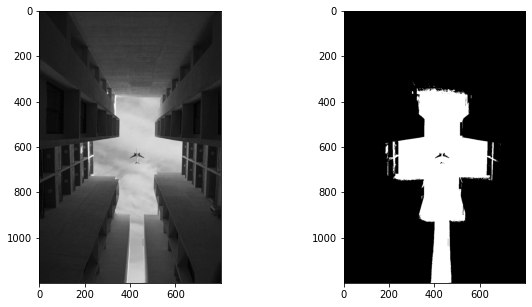

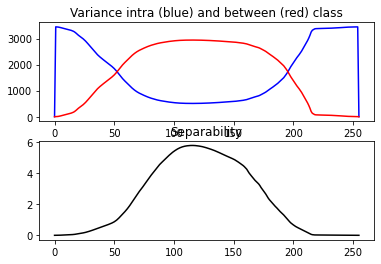

In [20]:
h,bins = np.histogram(im.flatten(),range(257))
plt.figure()
plt.bar(bins[:-1],h,bins[1]-bins[0])
plt.show()

t,vw,vb,sep = otsu_threshold(h)
print("Otsu threshold : %d"%t)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.subplot(1,2,2)
plt.imshow(im>t, cmap=plt.cm.gray)

plt.figure()
plt.subplot(2,1,1)
plt.plot(vw, 'b-')
plt.plot(vb, 'r-')
plt.title('Variance intra (blue) and between (red) class')
plt.subplot(2,1,2)
plt.plot(sep, 'k-')
plt.title('Separability')
plt.show()


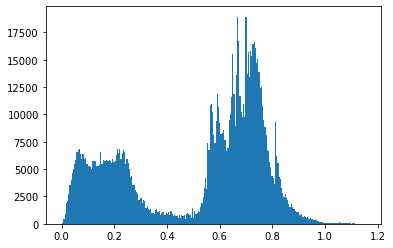

In [21]:
from skimage.color import rgb2hsv

def distance_color_space(im, coords):
    refcolor = im[coords[0],coords[1]]
    dmap = np.sqrt(((im-refcolor)**2).sum(axis=2))
    return dmap

im = imread('etretat.jpg')
hsv = rgb2hsv(im)

coords = (200,600)

dmap = distance_color_space(hsv.astype('float'), coords)
h,bins = np.histogram(dmap.flatten(),bins=256)

plt.figure()
plt.bar(bins[:-1],h,bins[1]-bins[0])
plt.show()

**Adaptive Thresholding (Gaussian Blurring)**

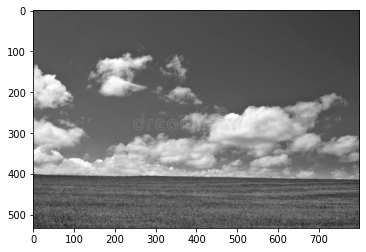

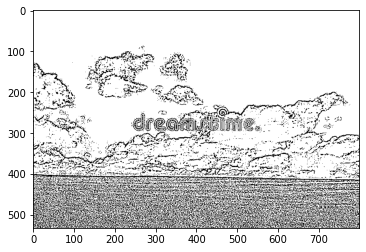

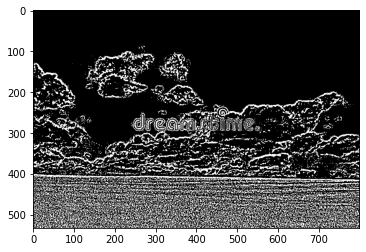

In [24]:
import cv2
image = cv2.imread('nature.jpg')

image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image, 'gray')
plt.show()

binarized = cv2.adaptiveThreshold(image, 255, 
                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                  cv2.THRESH_BINARY, 7, 3)
plt.imshow(binarized, 'gray')
plt.show()

binarized = cv2.adaptiveThreshold(image, 255, 
                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                  cv2.THRESH_BINARY_INV, 11, 3)
plt.imshow(binarized, 'gray')
plt.show()

**Sobel Region Descriptors**

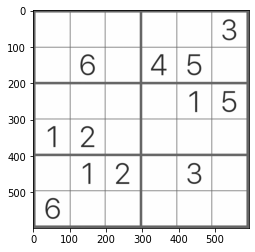

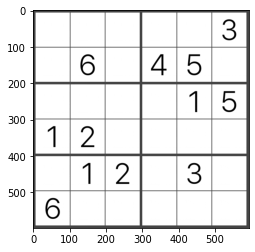

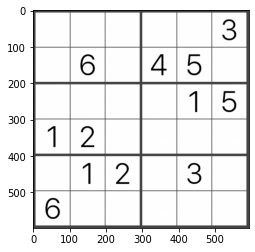

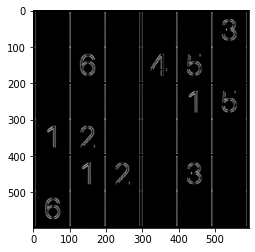

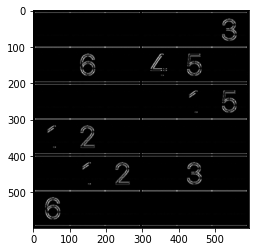

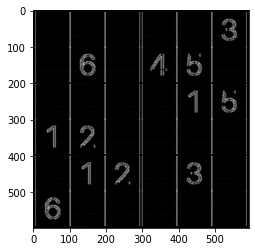

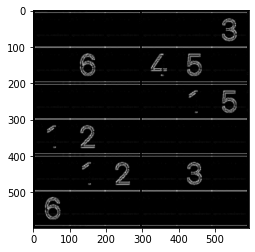

In [25]:
image = cv2.imread('sudoku.png')
plt.imshow(image)
plt.show()

image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image, 'gray')
plt.show()

image = cv2.bilateralFilter(image, 5, 50, 50)
plt.imshow(image, 'gray')
plt.show()

sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize = 3)
sobelx = np.uint8(np.absolute(sobelx))

sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize = 3)
sobely = np.uint8(np.absolute(sobely))

plt.imshow(sobelx, 'gray')
plt.show()

plt.imshow(sobely, 'gray')
plt.show()

scharx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize = -1)
scharx = np.uint8(np.absolute(scharx))

schary = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize = -1)
schary = np.uint8(np.absolute(schary))

plt.imshow(scharx, 'gray')
plt.show()

plt.imshow(schary, 'gray')
plt.show()

https://muthu.co/otsus-method-for-image-thresholding-explained-and-implemented/